In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn import svm

import dionysus as d
import sklearn_tda as tda

from biomarker.data_collection import *

Cython not found--WassersteinDistance not available
Gudhi not found--GraphInducedComplex not available
data_collection


In [2]:
EXCLUDE_KEYS = [206, 205, 184, 183, 82, 81, 45]
TEST_KEYS = [217, 216]#, 215, 214, 213, 212, 211, 210, 209]
NUM_TEST = 10
SIGMA = 1

C = 1
EPSILON = 0.1
GAMMA = 0.1
LIM = 5
MUL = 10

In [3]:
def compute_diagram(points, k=3):
    r = np.max(pdist(points, 'euclidean'))
    f = d.fill_rips(points, k, r)
    m = d.homology_persistence(f)
    return d.init_diagrams(m, f)

def get_max_diag_dim(dgms, h=1):
    m = 0
    for d in dgms:
        n = len(d[h])
        if n > m:
            m = n
    return m

def kernelize_diagrams_rbf(dgms, h=1, sigma=SIGMA, default=10):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                xi = np.zeros(((len(dgms[i][h]) if len(dgms[i][h]) > len(dgms[j][h]) else len(dgms[j][h])), 2))
                xj = np.zeros(xi.shape)
                if xj.shape[0] > 0:
                    for ip in range(len(dgms[i][h])):
                        xi[ip,0] = dgms[i][h][ip].birth
                        xi[ip,1] = dgms[i][h][ip].death
                    for jp in range(len(dgms[j][h])):
                        xj[jp,0] = dgms[j][h][ip].birth
                        xj[jp,1] = dgms[j][h][ip].death
                    xi[xi[:,1] >= 1E108] = 0
                    xj[xj[:,1] >= 1E108] = 0
                    D[i,j] = np.exp(np.power((np.linalg.norm(xi - xj, 2)), 2)/(2*sigma))
    #                 D[D >= 1E108] = 0
                else:
                    D[i,j] = 0
                D = np.nan_to_num(D)
    return D

def kernelize_diagrams(dgms, h=1, sigma=SIGMA):
    D = np.zeros(shape=(len(dgms), len(dgms)))
    for i in range(len(dgms)):
        print('step: ', i)
        for j in range(len(dgms)):
            if i == j:
                D[i,j] = 0.0
            else:
                D[i,j] = d.bottleneck_distance(dgms[i][h], dgms[j][h])
#                 D[i,j] = np.exp(d.wasserstein_distance(dgms[i][h], dgms[j][h], q=2)/2*sigma)
    D = np.nan_to_num(D)
    return D


def compute_sample_weights(y, lim=LIM, mul=MUL, up_lim=None, up_mul=None):
    ret = np.ones(y.shape[0])
    for i in range(y.shape[0]):
        v = y[i]
        if v < lim:
            ret[i] = np.abs(lim-v)*mul
        if up_lim is not None:
            if v > up_lim:
                if up_mul is not None:
                    ret[i] = np.abs(lim-v)*up_mul
                else:
                    ret[i] = np.abs(lim-v)*mul
    return ret

def create_train_test_matrices(train_keys, test_keys):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x5_train, x5_dims = create_x5_matrix(L_train, return_dims=True)
    x6_train, x6_dims = create_x6_matrix(L_train, return_dims=True)
    x7_train, x7_dims = create_x7_matrix(L_train, return_dims=True)
    
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x5_test = create_x5_matrix(L_test, max_dims=x5_dims)
    x6_test = create_x6_matrix(L_test, max_dims=x6_dims)
    x7_test = create_x7_matrix(L_test, max_dims=x7_dims)
    
    x50_x57_train = excel_train.iloc[:, 3:-2]
    master_train, master_names = prepare_master(x50_x57_train)
    
    x50_x57_test = excel_test.iloc[:, 3:-2]
    master_test, master_names = prepare_master(x50_x57_test)
    
    X_train = np.hstack((x5_train,x5_train,x5_train,x6_train,x7_train))
    X_test = np.hstack((x5_test, x5_test, x5_test, x6_test, x7_test))
    
    X = np.vstack((X_train,X_test))
    K = rbf_kernel(X)
    X_train = K[:len(y_train), :len(y_train)]
    X_test = K[len(y_train):, :len(y_train)]
    
    return (X_train, y_train), (X_test, y_test)

def create_train_test_diagram_kernels(train_keys, test_keys, h=1):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    test_idxs = list(excel[np.isin(excel['Key'], test_keys)].index)
    excel_test = excel.iloc[test_idxs]
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    excel_train = excel.drop(test_idxs, axis=0)
    L_train = get_filename_list(excel_train['Associated data'])
    y_train = excel_train['Output: logK'].values
    y_buck_train = excel_train['Output: logKbucket'].values
    
    print('Computing Training Diagrams')
    diags_train = []
    for l in L_train:
        diags_train.append(compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_train)):
        if len(diags_train[i][h]) == 0:
            diags_train[i] = np.array([[0,0]])
        else:
            diags_train[i] = np.array([[pt.birth,pt.death] for pt in diags_train[i][h]])
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_train + diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=1, bandwidth=1.)
    
    D = SW.fit_transform(dd)
    
    D_train = D[:len(y_train), :len(y_train)]
    D_test = D[len(y_train):, :len(y_train)]
    return (D_train, y_train), (D_test, y_test)
      
    
def create_test_diagram_kernels(h=1, num_directions=1, bandwidth=1.0):
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    excel_test = excel
    L_test = get_filename_list(excel_test['Associated data'])
    y_test = excel_test['Output: logK'].values
    y_buck_test = excel_test['Output: logKbucket'].values
    
    print('Computing Test Diagrams')
    diags_test = []
    for l in L_test:
        diags_test.append(compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values))
    for i in range(len(diags_test)):
        if len(diags_test[i][h]) == 0:
            diags_test[i] = np.array([[0,0]])
        else:
            diags_test[i] = np.array([[pt.birth,pt.death] for pt in diags_test[i][h]])
    
    print('Computing Kernel')
    
    dd = diags_test
    SW = tda.SlicedWassersteinKernel(num_directions=num_directions, bandwidth=bandwidth)
    
    D = SW.fit_transform(dd)
    
    return (D, y_test)

def get_diag(k, h=1): 
    excel = parse_master_file(exclude_keys=EXCLUDE_KEYS)
    l = get_filename_list(excel[excel['Key'] == k]['Associated data'])[0]
    dgm = compute_diagram(parse_x5(l)[['X', 'Y', 'Z']].values)
    return dgm
    
    

In [4]:
excel = parse_master_file(exclude_keys=EXCLUDE_KEYS).reset_index(drop=True)
keys = excel['Key']

[3, 9]


In [ ]:
test_set = create_test_diagram_kernels(num_directions=1, bandwidth=1.0)
D = test_set[0]
y = test_set[1]

In [5]:
x10_x17 = excel.iloc[:, 3:-3]
x10_x17.head()

,X10: Category Method,X11: Temperature (K),X12: [Salt*Valency],X13: Category Salt type,X14: [Buffer] (mM),X15: pH,X16: CI #,X17: CI
0,A,298.0,0,0,0,7.00,0,N
1,B,298.0,0,0,50,4.74,0,N
2,A,298.0,0,0,0,7.00,1,CI_2
3,A,298.0,0,0,0,7.00,2,CI_1
4,A,298.0,0,0,0,7.00,2,CI_2


In [6]:
master, master_names = prepare_master(x10_x17)

In [9]:
# K = rbf_kernel(master)
# K = linear_kernel(master)
K = master

In [ ]:
D = np.hstack((D, K))

In [ ]:
# train_set, test_set = create_train_test_matrices(train_keys, TEST_KEYS)
# X_train = train_set[0]
# X_test = test_set[0]
# print(X_train.shape)

In [ ]:
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 100, 'auto']
Cs = [0.1, 1, 10, 20, 50]
Epsilons = [1e-5, 1e-4, 1e-2, 1e-1, 1, 10]
num_directions = [1, 2, 3]
bandwidths = [1.0]
lims = [1, 2, 5, 7, 10]
up_lims = [1, 2, 5, 7, 10]
muls = [0.1, 1, 2, 3, 5, 10]
up_muls = [0.1, 1, 2, 3, 5, 10]

best_params = [0,0,0,0,0]
best_score = -float('inf')
best_cvs = None

up_lim = 0
up_mul = 0

for lim in lims:
#     for up_lim in up_lims:
#         for up_mul in up_muls:
    for mul in muls:
        for gamma in Gammas:
            for c in Cs:
                for eps in Epsilons:
                    clf = svm.SVR(kernel='rbf', epsilon=eps, C=c, gamma=gamma)
                    sws = compute_sample_weights(y, lim=lim, mul=mul)
                    cvs = cross_val_score(clf, D, y, cv=5, scoring='neg_median_absolute_error', fit_params={'sample_weight':sws})
                    print('lim: {}, mul: {}, up_lim: {}, up_mul: {}, gamma: {}, c: {}, epsilon: {}, Mean Cross-Validation Score: {}, Stddev: {}'.format(lim, mul, up_lim, up_mul, gamma, c, eps, cvs.mean(), cvs.std()))
                    if cvs.mean() > best_score:
                        best_score = cvs.mean()
                        best_cvs = cvs
                        best_params = [gamma, c, eps, lim, mul, up_lim, up_mul]

In [ ]:
print(best_score, best_params)

In [ ]:
Gammas = [1e-4, 1e-2, 1e-1, 1, 10, 100, 'auto']
Cs = [0.1, 1, 10, 20, 50]
Epsilons = [1e-5, 1e-4, 1e-2, 1e-1, 1, 10]
num_directions = [1, 2, 3]
bandwidths = [1.0]
lims = [1, 2, 5, 7, 10]
up_lims = [1, 2, 5, 7, 10]
muls = [0.1, 1, 2, 3, 5, 10]
up_muls = [0.1, 1, 2, 3, 5, 10]

best_params = [0,0,0,0,0]
best_score = -float('inf')
best_cvs = None

up_lim = 0
up_mul = 0
K = master

for direction in num_directions:
    for bandwidth in bandwidths:
        test_set = create_test_diagram_kernels(num_directions=direction, bandwidth=1.)
        D = test_set[0]
        y = test_set[1]
        K_train = np.delete(K, [191,192], axis=0)
        K_test = K[191:193]
        D_train = np.delete(np.delete(D, [191,192], axis=0), [191,192], axis=1)
        D_test = np.delete(D[191:193], [191,192], axis=1)
        y_train = np.delete(y, [191,192], 0)
        y_test = y[191:193]
#         D_train = np.hstack((D_train, K_train))
#         D_test = np.hstack((D_test, K_test))
        print(D_train.shape, D_test.shape, y_train.shape, y_test.shape)
        for lim in lims:
        #     for up_lim in up_lims:
        #         for up_mul in up_muls:
            for mul in muls:
                for gamma in Gammas:
                    for c in Cs:
                        for eps in Epsilons:
                            clf = svm.SVR(kernel='rbf', epsilon=eps, C=c, gamma=gamma)
                            sws = compute_sample_weights(y_train, lim=lim, mul=mul)
                            clf.fit(D_train, y_train, sample_weight=sws)
                            cvs = cross_val_score(clf, D_train, y_train, cv=5, scoring='neg_median_absolute_error', fit_params={'sample_weight':sws})
                            preds = clf.predict(D_test)
                            acc = metrics.mean_absolute_error(y_test, preds)
                            total_acc = (-acc + 10*cvs.mean())/2
                            print('lim: {}, mul: {}, direction: {}, gamma: {}, c: {}, epsilon: {}, Median Absolute Error: {}'.format(lim, mul, direction, gamma, c, eps, total_acc))
                            if total_acc > best_score:
                                best_score = total_acc
                                best_params = [gamma, c, eps, lim, mul, direction, bandwidth]

In [ ]:
print(best_score, best_params)

In [22]:
test_set = create_test_diagram_kernels(num_directions=3, bandwidth=2., h=1)
D = test_set[0]
y = test_set[1]

[3, 9]
Computing Test Diagrams
Computing Kernel


In [23]:
results = []
for i in range(D.shape[0]):
    mask = np.ones(D.shape, dtype=bool)
    mask[i,i] = False
    y_train = np.delete(y, i, 0)
    y_test = y[i]
    K_train = np.delete(K, i, axis=0)
    K_test = K[i].reshape(1,-1)
    D_train = np.delete(np.delete(D, i, axis=0), i, axis=1)
    D_test = np.delete(D[i], i, axis=0).reshape(1,-1)
    DD_train = np.hstack((D_train, K_train))
    DD_test = np.hstack((D_test, K_test))
    
#     sws = compute_sample_weights(y_train, lim=3, mul=1)
    
    DD_train = D_train
    DD_test = D_test
    clf = KernelRidge(kernel='precomputed', alpha=0.001)
#     clf = KernelRidge(kernel='linear', alpha=.001)

#     clf.fit(D_train,y_train)
#     clf = svm.SVR(kernel='precomputed', epsilon=0.01, C=10, gamma=.01)
#     clf = svm.LinearSVR(C=1, epsilon=0.1)
#     clf.fit(DD_train,y_train, sample_weight=sws)
    clf.fit(DD_train,y_train)
    prediction = clf.predict(DD_test)
    results.append({'predicted':prediction[0], 'actual':y_test, 'key':keys[i]})

In [24]:
res_df = pd.DataFrame(results)
print(np.median(np.abs(res_df['predicted'] - res_df['actual'])))
res_df.tail(10)

1.1320257212868818


,actual,key,predicted
186,7.95,211,8.295677
187,5.52,212,5.289614
188,8.74,213,9.771896
189,8.14,214,7.181626
190,4.00,215,6.593670
191,6.54,216,5.281609
192,0.00,217,6.248009
193,0.00,218,6.916098
194,0.00,219,7.856861
195,0.00,220,7.750216


Text(0,0.5,'Predicted logK')

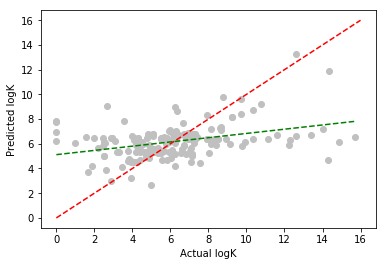

In [25]:
plt.scatter(res_df['actual'], res_df['predicted'], color='silver')
plt.plot([0,16],[0,16], 'r--')
plt.plot(np.unique(res_df['actual']), np.poly1d(np.polyfit(res_df['actual'], res_df['predicted'], 1))(np.unique(res_df['actual'])), 'g--')
plt.xlabel('Actual logK')
plt.ylabel('Predicted logK')

In [ ]:
res_df.to_csv('../data/results/actual_v_predicted_geom_x10-x17.csv', sep=',')

In [13]:
num_directions = [1, 2, 3]
bandwidths = [0.1, 1.0, 2.0]
alphas = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
best_params = [0,0,0,0,0]
best_score = -float('inf')
best_cvs = None

for direction in num_directions:
    for bandwidth in bandwidths:
        test_set = create_test_diagram_kernels(num_directions=direction, bandwidth=bandwidth)
        D = test_set[0]
        y = test_set[1]
        for alpha in alphas:
            clf = KernelRidge(kernel='linear', alpha=alpha)
            D_train = np.hstack((D, K))
            y_train = y
            cvs = cross_val_score(clf, D_train, y_train, cv=5, scoring='neg_median_absolute_error')
            total_acc = cvs.mean()
            print('direction: {}, bandwidth: {}, alpha: {}, Median Absolute Error: {}'.format(direction, bandwidth, alpha, total_acc))
            if total_acc > best_score:
                best_score = total_acc
                best_params = [alpha, direction, bandwidth]

[3, 9]
Computing Test Diagrams
Computing Kernel
direction: 1, bandwidth: 0.1, alpha: 0.01, Median Absolute Error: -2.359053281933069
direction: 1, bandwidth: 0.1, alpha: 0.001, Median Absolute Error: -2.5775686950683596
direction: 1, bandwidth: 0.1, alpha: 0.0001, Median Absolute Error: -2.89295311832428
direction: 1, bandwidth: 0.1, alpha: 1e-05, Median Absolute Error: -3.7221465759277343
direction: 1, bandwidth: 0.1, alpha: 1e-06, Median Absolute Error: -4.988648315429687
[3, 9]
Computing Test Diagrams
Computing Kernel
direction: 1, bandwidth: 1.0, alpha: 0.01, Median Absolute Error: -2.299562390424311
direction: 1, bandwidth: 1.0, alpha: 0.001, Median Absolute Error: -2.3232108087539673
direction: 1, bandwidth: 1.0, alpha: 0.0001, Median Absolute Error: -2.270301296234131
direction: 1, bandwidth: 1.0, alpha: 1e-05, Median Absolute Error: -2.5816091613769534
direction: 1, bandwidth: 1.0, alpha: 1e-06, Median Absolute Error: -2.975840026855469
[3, 9]
Computing Test Diagrams
Computing 

In [14]:
best_params

[0.0001, 3, 2.0]

[3, 9]


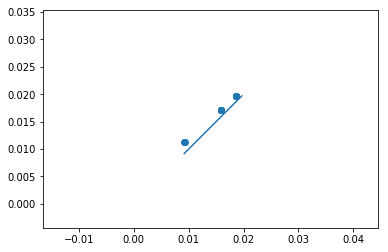

In [15]:
d.plot.plot_diagram(get_diag(220)[1])

[3, 9]


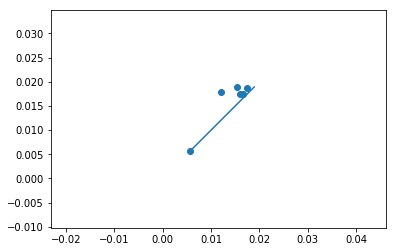

In [16]:
d.plot.plot_diagram(get_diag(217)[1])

[3, 9]


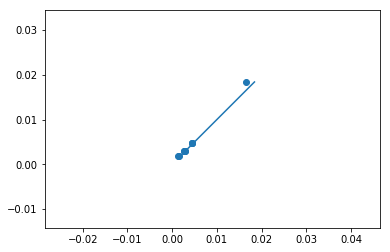

In [17]:
d.plot.plot_diagram(get_diag(215)[1])

In [18]:
res_df[res_df['predicted'] == res_df['predicted'].max()]

,actual,key,predicted
66,12.62,87,13.469471


[3, 9]


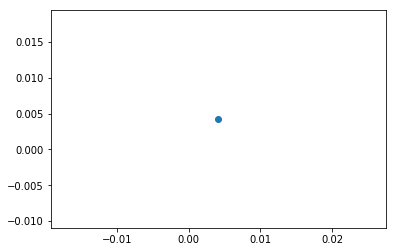

In [19]:
d.plot.plot_diagram(get_diag(90)[1])

In [20]:
res_df[res_df['predicted'] == res_df['predicted'].min()]

,actual,key,predicted
134,3.92,155,1.091651


[3, 9]


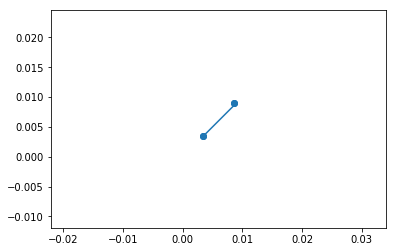

In [21]:
d.plot.plot_diagram(get_diag(44)[1])